### Lab 3: Expectation Maximization and Variational Autoencoder

### Machine Learning 2 (2019)

* The lab exercises can be done in groups of two people, or individually.
* The deadline is Tuesday, October 15th at 17:00.
* Assignment should be submitted through Canvas! Make sure to include your and your teammates' names with the submission.
* Attach the .IPYNB (IPython Notebook) file containing your code and answers. Naming of the file should be "studentid1\_studentid2\_lab#", for example, the attached file should be "12345\_12346\_lab1.ipynb". Only use underscores ("\_") to connect ids, otherwise the files cannot be parsed.

Notes on implementation:

* You should write your code and answers in an IPython Notebook: http://ipython.org/notebook.html. If you have problems, please ask.
* Use __one cell__ for code and markdown answers only!
    * Put all code in the cell with the ```# YOUR CODE HERE``` comment and overwrite the ```raise NotImplementedError()``` line.
    * For theoretical questions, put your solution using LaTeX style formatting in the YOUR ANSWER HERE cell.
* Among the first lines of your notebook should be "%pylab inline". This imports all required modules, and your plots will appear inline.
* Large parts of you notebook will be graded automatically. Therefore it is important that your notebook can be run completely without errors and within a reasonable time limit. To test your notebook before submission, select Kernel -> Restart \& Run All.
$\newcommand{\bx}{\mathbf{x}} \newcommand{\bpi}{\mathbf{\pi}} \newcommand{\bmu}{\mathbf{\mu}} \newcommand{\bX}{\mathbf{X}} \newcommand{\bZ}{\mathbf{Z}} \newcommand{\bz}{\mathbf{z}}$

### Installing PyTorch

In this lab we will use PyTorch. PyTorch is an open source deep learning framework primarily developed by Facebook's artificial-intelligence research group. In order to install PyTorch in your conda environment go to https://pytorch.org and select your operating system, conda, Python 3.6, no cuda. Copy the text from the "Run this command:" box. Now open a terminal and activate your 'ml2labs' conda environment. Paste the text and run. After the installation is done you should restart Jupyter.

### MNIST data

In this Lab we will use several methods for unsupervised learning on the MNIST dataset of written digits. The dataset contains digital images of handwritten numbers $0$ through $9$. Each image has 28x28 pixels that each take 256 values in a range from white ($= 0$) to  black ($=1$). The labels belonging to the images are also included. 
Fortunately, PyTorch comes with a MNIST data loader. The first time you run the box below it will download the MNIST data set. That can take a couple of minutes.
The main data types in PyTorch are tensors. For Part 1, we will convert those tensors to numpy arrays. In Part 2, we will use the torch module to directly work with PyTorch tensors.

In [1]:
%pylab inline
import torch
from torchvision import datasets, transforms

train_dataset = datasets.MNIST('../data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ]))

train_labels = train_dataset.train_labels.numpy()
train_data = train_dataset.train_data.numpy()
# For EM we will use flattened data
train_data = train_data.reshape(train_data.shape[0], -1)


Populating the interactive namespace from numpy and matplotlib


100.1%

Extracting ../data\MNIST\raw\train-images-idx3-ubyte.gz


113.5%

Extracting ../data\MNIST\raw\train-labels-idx1-ubyte.gz


100.4%

Extracting ../data\MNIST\raw\t10k-images-idx3-ubyte.gz


180.4%

Extracting ../data\MNIST\raw\t10k-labels-idx1-ubyte.gz
Processing...
Done!


C:\Users\sgraaf\Miniconda3\envs\ml2labs\lib\site-packages\torchvision\datasets\mnist.py:43: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")
C:\Users\sgraaf\Miniconda3\envs\ml2labs\lib\site-packages\torchvision\datasets\mnist.py:53: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


## Part 1: Expectation Maximization
We will use the Expectation Maximization (EM) algorithm for the recognition of handwritten digits in the MNIST dataset. The images are modelled as a Bernoulli mixture model (see Bishop $\S9.3.3$):
$$
p(\bx|\bmu, \bpi) = \sum_{k=1}^K  \pi_k \prod_{i=1}^D \mu_{ki}^{x_i}(1-\mu_{ki})^{(1-x_i)}
$$
where $x_i$ is the value of pixel $i$ in an image, $\mu_{ki}$ represents the probability that pixel $i$ in class $k$ is black, and $\{\pi_1, \ldots, \pi_K\}$ are the mixing coefficients of classes in the data. We want to use this data set to classify new images of handwritten numbers.

### 1.1 Binary data (5 points)
As we like to apply our Bernoulli mixture model, write a function `binarize` to convert the (flattened) MNIST data to binary images, where each pixel $x_i \in \{0,1\}$, by thresholding at an appropriate level.

In [2]:
def binarize(X):
    bin_X = []
    threshold = round(np.max(train_data.flatten()) / 2)
    for img in X:
        bin_img = 1.0 * (img >= threshold)
        bin_X.append(bin_img)
    return np.asarray(bin_X, dtype=float)



In [3]:
# Test test test!
bin_train_data = binarize(train_data)
assert bin_train_data.dtype == np.float
assert bin_train_data.shape == train_data.shape


Sample a few images of digits $2$, $3$ and $4$; and show both the original and the binarized image together with their label.

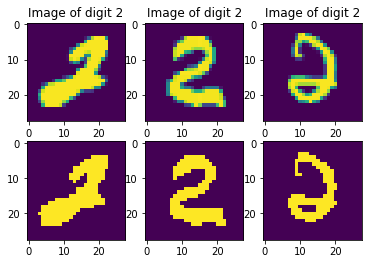

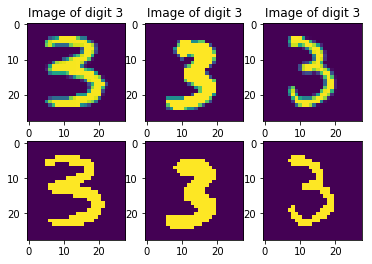

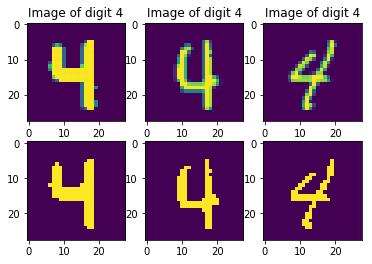

In [4]:
from matplotlib import pyplot as plt
np.random.seed(2018)

def select_few(train_labels, few):
    to_print_ind = [np.random.choice(np.argwhere(train_labels == 2).flatten(), size=few),
                   np.random.choice(np.argwhere(train_labels == 3).flatten(), size=few),
                   np.random.choice(np.argwhere(train_labels == 4).flatten(), size=few)]
    return to_print_ind

def reshape_digit(row):
    return np.reshape(row, (int(np.sqrt(len(row))),
                                     int(np.sqrt(len(row)))))
def plot_digit(reshaped):
    plt.imshow(reshaped, interpolation='nearest')

few = 3
to_print_ind = select_few(train_labels, few)
for ind_class in to_print_ind:
    for no, img_ind in enumerate(ind_class):
        flat = train_data[img_ind]
        bin_img = bin_train_data[img_ind]
        to_print = reshape_digit(flat)
        to_print_bin = reshape_digit(bin_img)
        
        label = train_labels[img_ind]

        plt.subplot(2, few, no + 1)
        plt.title(f'Image of digit {label}')
        plot_digit(to_print)
        plt.subplot(2, few, no + 1 + few)
        plot_digit(to_print_bin)
    plt.show()


### 1.2 Implementation (40 points)
You are going to write a function ```EM(X, K, max_iter)``` that implements the EM algorithm on the Bernoulli mixture model. 

The only parameters the function has are:
* ```X``` :: (NxD) array of input training images
* ```K``` :: size of the latent space
* ```max_iter``` :: maximum number of iterations, i.e. one E-step and one M-step

You are free to specify your return statement.

Make sure you use a sensible way of terminating the iteration process early to prevent unnecessarily running through all epochs. Vectorize computations using ```numpy``` as  much as possible.

You should implement the `E_step(X, mu, pi)` and `M_step(X, gamma)` separately in the functions defined below. These you can then use in your function `EM(X, K, max_iter)`.

In [5]:
def E_step(X, mu, pi):
    # Shape of X is NxD
    # Shape of mu is KxD
    # Shape of pi is Kx1

    X_prior = [] # calculating p(x|mu) for all datapoints and all classes
    for n, x in enumerate(X):
        temp_prior = []
        for k, m in enumerate(mu):
            prob = np.multiply(m**x, (1-m)**(1-x))
            temp_prior.append(np.product(prob))
        X_prior.append(np.asarray(temp_prior))
    #[np.asarray([img @ mu.T for img in X])]
    # Shape of X_prior is NxK

    gamma = np.asarray(X_prior)
    for no, row in enumerate(gamma):
        gamma[no] = np.multiply(row, pi) # calculating gamma by multiplying each row of prior by pi
    # Shape of gamma is NxK
    
    gamma_norm = np.sum(gamma, axis=1) # normalization constant
    # Shape of gamma_norm is Nx1
    for no, row in enumerate(gamma):
        gamma[no] = row / gamma_norm[no]
    return gamma

In [6]:
# Let's test on 5 datapoints
n_test = 5
X_test = bin_train_data[:n_test]
D_test, K_test = X_test.shape[1], 10

np.random.seed(2018)
mu_test = np.random.uniform(low=.25, high=.75, size=(K_test,D_test))
pi_test = np.ones(K_test) / K_test

gamma_test = E_step(X_test, mu_test, pi_test)
assert gamma_test.shape == (n_test, K_test)


In [7]:
def M_step(X, gamma):
    # Shape of X is NxD
    # Shape of gamma is NxK

    Nk = np.sum(gamma, axis=0)
    # Shape of Nk is Kx1
    pi = Nk / np.sum(Nk)
    # Shape of pi is Kx1
    
    mu = []
    for no in range(gamma.shape[1]):
        mu.append(gamma[:,no].T @ X / Nk[no])
    # Shape of mu is KxD
    
    return np.asarray(mu), pi

In [8]:
# Oh, let's test again
mu_test, pi_test = M_step(X_test, gamma_test)

assert mu_test.shape == (K_test,D_test)
assert pi_test.shape == (K_test, )


In [9]:
def EM(X, K, max_iter, mu=None, pi=None, printed=True):
    if mu is None:
        mu = np.random.uniform(low=.25, high=.75, size=(K,X.shape[1]))
    if pi is None:
        pi = np.ones(K) / K
    for i in range(max_iter):
        # Run E and M steps
        gamma = E_step(X, mu, pi)
        mu_new, pi_new = M_step(X, gamma)
        
        # Calculate change in parameters
        mu_change = np.mean(np.divide((mu_new - mu), mu, where=mu!=0))
        pi_change = np.mean(np.divide((pi_new - pi), pi))
        if printed:
            if max_iter > 50 and i % 10 == 0:
                print(f'Iter {i+1} out of {max_iter}. Change in mu: {mu_change*100}%. Change in pi: {pi_change*100}%') 
        mu, pi = mu_new, pi_new
        
        #Check if early stopping needed
        if abs(mu_change) < 1e-6 and abs(pi_change) < 1e-6:
            if printed: 
                print(f'Early stop at iteration {i}.')
            break
    return mu, pi

### 1.3 Three digits experiment (10 points)
In analogue with Bishop $\S9.3.3$, sample a training set consisting of only __binary__ images of written digits $2$, $3$, and $4$. Run your EM algorithm and show the reconstructed digits.

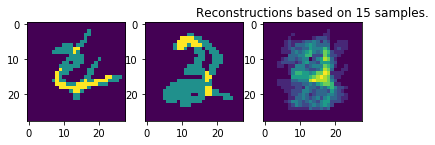

Mixing coefficients for are: [0.13333333 0.13333333 0.73333333]


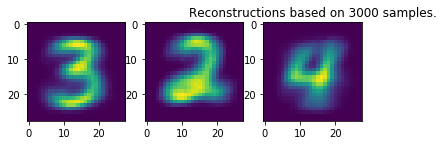

Mixing coefficients are: [0.35533809 0.24988935 0.39477256]


In [10]:
# Run EM on 5 samples each from classes 2,3,4
sample_small = 5
to_print_ind_small = select_few(train_labels, sample_small)
bin_test_train_small = bin_train_data[np.asarray(to_print_ind_small).flatten()]
mu_small, pi_small = EM(bin_test_train_small, 3, 50, printed=True)

# Run EM on 1000 samples each from classes 2,3,4
sample_large = 1000
to_print_ind = select_few(train_labels, sample_large)
bin_test_train = bin_train_data[np.asarray(to_print_ind).flatten()]
mu_pred, pi_pred = EM(bin_test_train, 3, 1000, printed=False)

def reconstruct_image(mu, samples):
    if mu.ndim != 1:
        for no, row in enumerate(mu):
            plt.subplot(1, len(mu), no + 1)
            plot_digit(reshape_digit(row))            
    else: 
        plot_digit(reshape_digit(mu))
    plt.title(f'Reconstructions based on {samples} samples.')
    plt.show()

# Plot and report results
reconstruct_image(mu_small, len(bin_test_train_small))
print(f'Mixing coefficients for are: {pi_small}') 
reconstruct_image(mu_pred, len(bin_test_train))
print(f'Mixing coefficients are: {pi_pred}')        

Can you identify which element in the latent space corresponds to which digit? What are the identified mixing coefficients for digits $2$, $3$ and $4$, and how do these compare to the true ones?

#### Answer: 
If we reconstruct the latent space for the three classes, namely $\mu_1, \mu_2, \mu_3$, we can see that they have general features of the corresponding ground truth labels. The reconstructions are noisy since we take a sample size of 15 (5 images per class). As we can see, once we increase the sample size, the signal becomes more easily noticeable. 
The mixing coefficients should approximate the distribution of classes in the original dataset, and as can be seen in the case for 300 samples, the $\pi_1, \pi_2, \pi_3$ roughly resemble a uniform distribution. 

### 1.4 Experiments (20 points)
Perform the follow-up experiments listed below using your implementation of the EM algorithm. For each of these, describe/comment on the obtained results and give an explanation. You may still use your dataset with only digits 2, 3 and 4 as otherwise computations can take very long.

#### 1.4.1 Size of the latent space (5 points)
Run EM with $K$ larger or smaller than the true number of classes. Describe your results.

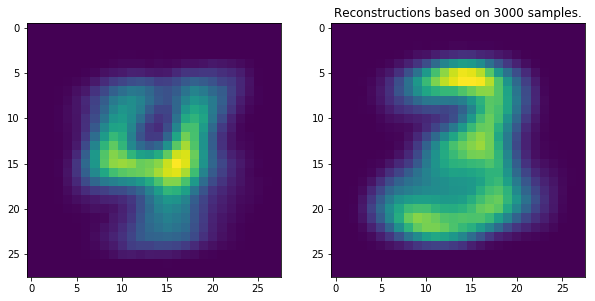

Mixing coefficients are: [0.39801884 0.60198116]


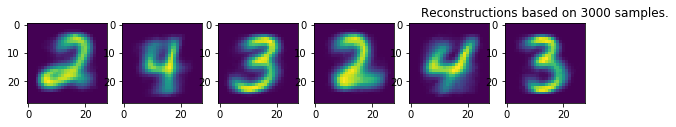

Mixing coefficients are: [0.12443744 0.21177334 0.15070908 0.19727362 0.16031739 0.15548913]


In [12]:
to_print_ind = select_few(train_labels, sample_large)
bin_test_train = bin_train_data[np.asarray(to_print_ind).flatten()]

# Run EM on smaller number of true classes
mu_less, pi_less = EM(bin_test_train, 2, 1000, printed=False)
plt.figure(figsize=(10,5))
reconstruct_image(mu_less, len(bin_test_train))
print(f'Mixing coefficients are: {pi_less}') 

# Run EM on larger number of true classes
mu_more, pi_more = EM(bin_test_train, 6, 1000, printed=False)
plt.figure(figsize=(10,5))
reconstruct_image(mu_more, len(bin_test_train))
print(f'Mixing coefficients are: {pi_more}')        


#### Answer:
The following reconstructed $\mu_i$ images and mixing coefficients were obtained by training on 3000 samples from 3 classes. As can be seen, the number of classes for the training process was underreported in the first case (2 classes) and overreported in the second case (6 classes). 

In the case of too few classes, we can see that the model leaned towards reconstructing means resembling those of digits 4 and 3. However, if we look at the mixing coefficients, we can see that $\pi_2 > \pi_1$, which allows us to speculate that samples of digit 2 were "classified" as digits 3. 

If we look at the results from training on too many classes, we can see that the model distinguished the three separate classes, clearly marking that $\mu_4, \mu_5$ correspond to digit 2 (note that $\pi_4+\pi_5=0,3295$, indicating that those two classes probably cover majority of samples that are indeed digit 2) and that $\mu_3, \mu_6$ correspond to digit 4(note that $\pi_3+\pi_6 = 0,2754$). As we can see, there is only one artificial class $\mu_2$ that clearly corresponds with digit 3, and the corresponding $\pi_2$ is quite large. Therefore, we can speculate that $\mu_1, \pi_1$ might correspond to a mixture of classes 3 and 4. 


#### 1.4.2 Identify misclassifications (10 points)
How can you use the data labels to assign a label to each of the clusters/latent variables? Use this to identify images that are 'misclassified' and try to understand why they are. Report your findings.

Accuracy for the trained model is 89.43333333333334%


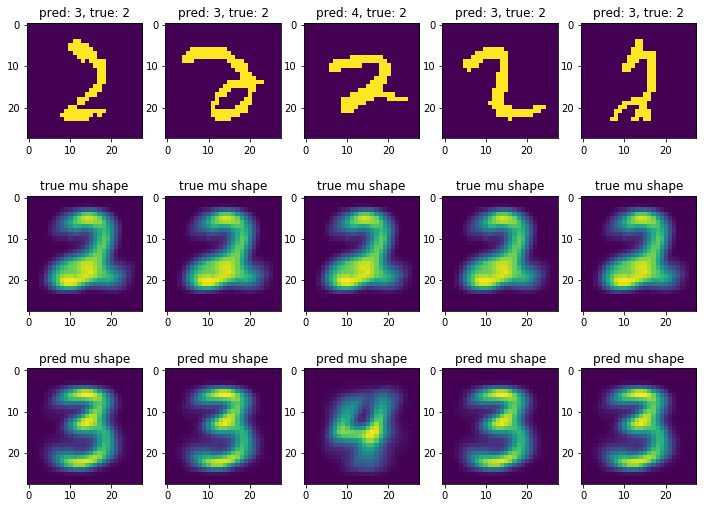

In [13]:
def get_predict_set(X, mu, true_labels):
    # Function that generates the corresponding label for each mu
    unique_labels = np.unique(true_labels)
    
    true_centers = []
    for unique in unique_labels:
        true_centers.append([row for no, row in enumerate(X) if true_labels[no] == unique])
    for no, label in enumerate(true_centers):
        true_centers[no] = np.mean(label, axis=0)
    predict_set = []
    for m in mu:
        distances = [np.linalg.norm(m-center) for center in true_centers]
        predict_set.append(unique_labels[np.argmin(distances)])

    return np.asarray(predict_set)        
        
def get_predictions(X, mu, true_labels, predict_set):
    # Function that returns predictions and accuracy given true labels and the set of labels for each mu
    predictions = []
    for sample in X:
        distances = [np.linalg.norm(sample - m) for m in mu]
        predictions.append(predict_set[np.argmin(distances)])    
    predictions = np.asarray(predictions)
    
    accuracy = np.sum(1.0 * (predictions == true_labels)) / len(predictions)
    misclassified = predictions != true_labels
    
    return predictions, accuracy, misclassified

# Get all the data needed to analyze the classifications
bin_true_labels = train_labels[np.asarray(to_print_ind).flatten()]
predict_set = get_predict_set(bin_test_train, mu_pred, bin_true_labels)
preds, acc, missclassified = get_predictions(bin_test_train, mu_pred, bin_true_labels, predict_set)
mis_ind = np.random.choice(np.argwhere(missclassified == True).flatten(), size=5)
# Analysis and plots
print(f'Accuracy for the trained model is {acc*100}%')
plt.figure(figsize=(12,9))
for no, mis in enumerate(mis_ind):
    plt.subplot(3, len(bin_test_train[mis_ind]), no + 1)
    plt.title(f'pred: {preds[mis]}, true: {bin_true_labels[mis]}')
    plot_digit(reshape_digit(bin_test_train[mis]))
for no, mis in enumerate(mis_ind):
    plt.subplot(3, len(bin_test_train[mis_ind]), len(bin_test_train[mis_ind]) + no + 1)
    plt.title(f'true mu shape')
    plot_digit(reshape_digit(mu_pred[bin_true_labels[mis] == predict_set].flatten()))    
for no, mis in enumerate(mis_ind):
    plt.subplot(3, len(bin_test_train[mis_ind]), 2*len(bin_test_train[mis_ind]) + no + 1)
    plt.title(f'pred mu shape')
    plot_digit(reshape_digit(mu_pred[preds[mis] == predict_set].flatten()))    

plt.show()

#### Answer:

To classify the predictions, I first calculated the average value of the "true" classes 2,3,4 and then observed which $\mu_1, \mu_2, \mu_3$ is closest to which "true" class center; as a result we have decided which $K$ corresponds to which "true" class. Having this, we can classify the predictions as correct and incorrect. 

On a trained model, we achieve 90% accuracy. We also provide examples of missclassified samples, and plot them against the reconstructed $\mu_i$ corresponding to the true label and $\mu_j$ corresponding to the predicted label. As can be seen, these samples do not resemble the average values of their corresponding classes, which might be the reason for misclassification. As can be clearly seen on 1st sample, the lower part of the written digit corresponds to the area that is activated in $\mu$ corresponding to class of digit 2. Similarly, on 3rd sample is it noticeable that there is a thick line that goes across the center of the image, and this same line is present in $\mu$ corresponding to class of digit 4. 

#### 1.4.3 Initialize with true values (5 points)
Initialize the three classes with the true values of the parameters and see what happens. Report your results.

Iter 1 out of 1000. Change in mu: -65.5235033775944%. Change in pi: 3.700743415417188e-15%
Iter 11 out of 1000. Change in mu: 8.180883495158447e+27%. Change in pi: 0.2766839184049777%
Iter 21 out of 1000. Change in mu: 1137.0174522796922%. Change in pi: 0.0008324949264985141%
Iter 31 out of 1000. Change in mu: 1332.6570678486937%. Change in pi: 2.0055978052931156e-06%
Iter 41 out of 1000. Change in mu: 1333.090538775011%. Change in pi: 4.042688249680779e-09%
Iter 51 out of 1000. Change in mu: 2109.606297680133%. Change in pi: 0.0008623864982606368%
Iter 61 out of 1000. Change in mu: -22.131203552091826%. Change in pi: 5.3347102959158414e-05%
Iter 71 out of 1000. Change in mu: -22.589319686676156%. Change in pi: 0.00036360267771054207%
Iter 81 out of 1000. Change in mu: -22.59130366667809%. Change in pi: 5.987941948124399e-07%
Iter 91 out of 1000. Change in mu: -22.592152881004342%. Change in pi: 2.3682842462246026e-09%
Iter 101 out of 1000. Change in mu: -22.59260086614994%. Change in 

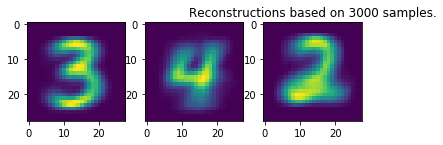

Mixing coefficients are: [0.30322047 0.38161975 0.31515978]
Iter 1 out of 1000. Change in mu: 0.2837046013896311%. Change in pi: 0.0%
Iter 11 out of 1000. Change in mu: 0.20365303058221315%. Change in pi: 0.0%
Iter 21 out of 1000. Change in mu: 0.20365303058221315%. Change in pi: 0.0%
Iter 31 out of 1000. Change in mu: 0.20365303058221315%. Change in pi: 0.0%
Iter 41 out of 1000. Change in mu: 0.20365303058221315%. Change in pi: 0.0%
Iter 51 out of 1000. Change in mu: 0.20365303058221315%. Change in pi: 0.0%
Iter 61 out of 1000. Change in mu: 0.20365303058221315%. Change in pi: 0.0%
Iter 71 out of 1000. Change in mu: 0.20365303058221315%. Change in pi: 0.0%
Iter 81 out of 1000. Change in mu: 0.20365303058221318%. Change in pi: 0.0%
Iter 91 out of 1000. Change in mu: 0.20365303058221315%. Change in pi: 0.0%
Iter 101 out of 1000. Change in mu: 0.20365303058221315%. Change in pi: 0.0%
Iter 111 out of 1000. Change in mu: 0.20365303058221315%. Change in pi: 0.0%
Iter 121 out of 1000. Change

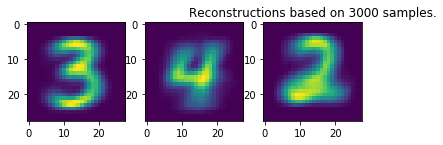

Mixing coefficients are: [0.30322047 0.38161975 0.31515978]


In [14]:
to_print_ind = select_few(train_labels, 1000)
bin_test_train = bin_train_data[np.asarray(to_print_ind).flatten()]

# Run EM to obtain true values of parameters
mu_true, pi_true = EM(bin_test_train, 3, 1000, printed=True)
reconstruct_image(mu_true, len(bin_test_train))
print(f'Mixing coefficients are: {pi_true}') 

# Run EM with true parameter values as parameters
mu_on_true, pi_on_true = EM(bin_test_train, 3, 1000, mu=mu_true, pi=pi_true, printed=True)
reconstruct_image(mu_on_true, len(bin_test_train))
print(f'Mixing coefficients are: {pi_on_true}') 


#### Answer:
Here we can see that if we take the values of $\mu, \pi$ from an already converged model and insert them to a new EM instance, the model convergence very quickly. Whereas for the original training it took 113 iterations, on the "true" parameters the values converged already after 7 iterations. From the reconstructed images and the mixing coefficients we can also see that the parameters do not change significantly, yielding almost identical results. 


## Part 2: Variational Auto-Encoder

A Variational Auto-Encoder (VAE) is a probabilistic model $p(\bx, \bz)$ over observed variables $\bx$ and latent variables and/or parameters $\bz$. Here we distinguish the decoder part, $p(\bx | \bz) p(\bz)$ and an encoder part $p(\bz | \bx)$ that are both specified with a neural network. A lower bound on the log marginal likelihood $\log p(\bx)$ can be obtained by approximately inferring the latent variables z from the observed data x using an encoder distribution $q(\bz| \bx)$ that is also specified as a neural network. This lower bound is then optimized to fit the model to the data. 

The model was introduced by Diederik Kingma (during his PhD at the UVA) and Max Welling in 2013, https://arxiv.org/abs/1312.6114. 

Since it is such an important model there are plenty of well written tutorials that should help you with the assignment. E.g: https://jaan.io/what-is-variational-autoencoder-vae-tutorial/.

In the following, we will make heavily use of the torch module, https://pytorch.org/docs/stable/index.html. Most of the time replacing `np.` with `torch.` will do the trick, e.g. `np.sum` becomes `torch.sum` and `np.log` becomes `torch.log`. In addition, we will use `torch.FloatTensor()` as an equivalent to `np.array()`. In order to train our VAE efficiently we will make use of batching. The number of data points in a batch will become the first dimension of our data tensor, e.g. A batch of 128 MNIST images has the dimensions [128, 1, 28, 28]. To check check the dimensions of a tensor you can call `.size()`.

### 2.1 Loss function
The objective function (variational lower bound), that we will use to train the VAE, consists of two terms: a log Bernoulli loss (reconstruction loss) and a Kullback–Leibler divergence. We implement the two terms separately and combine them in the end.
As seen in Part 1: Expectation Maximization, we can use a multivariate Bernoulli distribution to model the likelihood $p(\bx | \bz)$ of black and white images. Formally, the variational lower bound is maximized but in PyTorch we are always minimizing therefore we need to calculate the negative log Bernoulli loss and Kullback–Leibler divergence.

### 2.1.1 Negative Log Bernoulli loss (5 points)
The negative log Bernoulli loss is defined as,

\begin{align}
loss = - (\sum_i^D \bx_i \log \hat{\bx_i} + (1 − \bx_i) \log(1 − \hat{\bx_i})).
\end{align}

Write a function `log_bernoulli_loss` that takes a D dimensional vector `x`, its reconstruction `x_hat` and returns the negative log Bernoulli loss. Make sure that your function works for batches of arbitrary size.

In [24]:
def log_bernoulli_loss(x_hat, x):
    
    # YOUR CODE HERE
    # raise NotImplementedError()
    loss = - torch.sum(x * torch.log(x_hat) + (1 - x) * torch.log(1 - x_hat))
    return loss


In [25]:
### Test test test
x_test = torch.FloatTensor([[0.1, 0.2, 0.3, 0.4], [0.5, 0.6, 0.7, 0.8], [0.9, 0.9, 0.9, 0.9]])
x_hat_test = torch.FloatTensor([[0.11, 0.22, 0.33, 0.44], [0.55, 0.66, 0.77, 0.88], [0.99, 0.99, 0.99, 0.99]])

assert log_bernoulli_loss(x_hat_test, x_test) > 0.0
assert log_bernoulli_loss(x_hat_test, x_test) < 10.0


### 2.1.2 Negative Kullback–Leibler divergence (10 Points)
The variational lower bound (the objective to be maximized) contains a KL term $D_{KL}(q(\bz)||p(\bz))$ that can often be calculated analytically. In the VAE we assume $q = N(\bz, \mu, \sigma^2I)$ and $p = N(\bz, 0, I)$. Solve analytically!

YOUR ANSWER HERE

Write a function `KL_loss` that takes two J dimensional vectors `mu` and `logvar` and returns the negative Kullback–Leibler divergence. Where `logvar` is $\log(\sigma^2)$. Make sure that your function works for batches of arbitrary size.

In [28]:
def KL_loss(mu, logvar):
    
    # YOUR CODE HERE
    # raise NotImplementedError()
    loss = - 0.5 * torch.sum(1 + logvar - mu.pow(2) - torch.exp(logvar))
    return loss


In [29]:
### Test test test
mu_test = torch.FloatTensor([[0.1, 0.2], [0.3, 0.4], [0.5, 0.6]])
logvar_test = torch.FloatTensor([[0.01, 0.02], [0.03, 0.04], [0.05, 0.06]])

assert KL_loss(mu_test, logvar_test) > 0.0
assert KL_loss(mu_test, logvar_test) < 10.0


### 2.1.3 Putting the losses together (5 points)
Write a function `loss_function` that takes a D dimensional vector `x`, its reconstruction `x_hat`, two J dimensional vectors `mu` and `logvar` and returns the final loss. Make sure that your function works for batches of arbitrary size.

In [30]:
def loss_function(x_hat, x, mu, logvar):
    
    # YOUR CODE HERE
    # raise NotImplementedError()
    loss = log_bernoulli_loss(x_hat, x) + KL_loss(mu, logvar)
    return loss


In [31]:
x_test = torch.FloatTensor([[0.1, 0.2, 0.3], [0.4, 0.5, 0.6], [0.7, 0.8, 0.9]])
x_hat_test = torch.FloatTensor([[0.11, 0.22, 0.33], [0.44, 0.55, 0.66], [0.77, 0.88, 0.99]])
mu_test = torch.FloatTensor([[0.1, 0.2], [0.3, 0.4], [0.5, 0.6]])
logvar_test = torch.FloatTensor([[0.01, 0.02], [0.03, 0.04], [0.05, 0.06]])

assert loss_function(x_hat_test, x_test, mu_test, logvar_test) > 0.0
assert loss_function(x_hat_test, x_test, mu_test, logvar_test) < 10.0


### 2.2 The model
Below you see a data structure for the VAE. The modell itself consists of two main parts the encoder (images $\bx$ to latent variables $\bz$) and the decoder (latent variables $\bz$ to images $\bx$). The encoder is using 3 fully-connected layers, whereas the decoder is using fully-connected layers. Right now the data structure is quite empty, step by step will update its functionality. For test purposes we will initialize a VAE for you. After the data structure is completed you will do the hyperparameter search.


In [32]:
from torch import nn
from torch.nn import functional as F 

class VAE(nn.Module):
    def __init__(self, fc1_dims, fc21_dims, fc22_dims, fc3_dims, fc4_dims):
        super(VAE, self).__init__()

        self.fc1 = nn.Linear(*fc1_dims)
        self.fc21 = nn.Linear(*fc21_dims)
        self.fc22 = nn.Linear(*fc22_dims)
        self.fc3 = nn.Linear(*fc3_dims)
        self.fc4 = nn.Linear(*fc4_dims)

    def encode(self, x):
        # To be implemented
        raise Exception('Method not implemented')

    def reparameterize(self, mu, logvar):
        # To be implemented
        raise Exception('Method not implemented')

    def decode(self, z):
        # To be implemented
        raise Exception('Method not implemented')

    def forward(self, x):
        # To be implemented
        raise Exception('Method not implemented')

VAE_test = VAE(fc1_dims=(784, 4), fc21_dims=(4, 2), fc22_dims=(4, 2), fc3_dims=(2, 4), fc4_dims=(4, 784))


### 2.3 Encoding (10 points)
Write a function `encode` that gets a vector `x` with 784 elements (flattened MNIST image) and returns `mu` and `logvar`. Your function should use three fully-connected layers (`self.fc1()`, `self.fc21()`, `self.fc22()`). First, you should use `self.fc1()` to embed `x`. Second, you should use `self.fc21()` and `self.fc22()` on the embedding of `x` to compute `mu` and `logvar` respectively. PyTorch comes with a variety of activation functions, the most common calls are `F.relu()`, `F.sigmoid()`, `F.tanh()`. Make sure that your function works for batches of arbitrary size.  

In [33]:
def encode(self, x):
    
    # YOUR CODE HERE
    # raise NotImplementedError()
    x_embed = F.relu(self.fc1(x))
    mu = self.fc21(x_embed)
    logvar = self.fc22(x_embed)
    return mu, logvar


In [34]:
### Test, test, test
VAE.encode = encode

x_test = torch.ones((5,784))
mu_test, logvar_test = VAE_test.encode(x_test)

assert np.allclose(mu_test.size(), [5, 2])
assert np.allclose(logvar_test.size(), [5, 2])


### 2.4 Reparameterization (10 points)
One of the major question that the VAE is answering, is 'how to take derivatives with respect to the parameters of a stochastic variable?', i.e. if we are given $\bz$ that is drawn from a distribution $q(\bz|\bx)$, and we want to take derivatives. This step is necessary to be able to use gradient-based optimization algorithms like SGD.
For some distributions, it is possible to reparameterize samples in a clever way, such that the stochasticity is independent of the parameters. We want our samples to deterministically depend on the parameters of the distribution. For example, in a normally-distributed variable with mean $\mu$ and standard deviation $\sigma$, we can sample from it like this:

\begin{align}
\bz = \mu + \sigma \odot \epsilon,
\end{align}

where $\odot$ is the element-wise multiplication and $\epsilon$ is sampled from $N(0, I)$.


Write a function `reparameterize` that takes two J dimensional vectors `mu` and `logvar`. It should return $\bz = \mu + \sigma \odot \epsilon$.


In [35]:
def reparameterize(self, mu, logvar):
            
        # YOUR CODE HERE
        # raise NotImplementedError()
        z = mu + torch.sqrt(torch.exp(logvar)) * torch.randn(mu.size())
        return z


In [36]:
### Test, test, test
VAE.reparameterize = reparameterize
VAE_test.train()

mu_test = torch.FloatTensor([[0.1, 0.2], [0.3, 0.4], [0.5, 0.6]])
logvar_test = torch.FloatTensor([[0.01, 0.02], [0.03, 0.04], [0.05, 0.06]])

z_test = VAE_test.reparameterize(mu_test, logvar_test)

assert np.allclose(z_test.size(), [3, 2])
assert z_test[0][0] < 5.0
assert z_test[0][0] > -5.0


### 2.5 Decoding (10 points)
Write a function `decode` that gets a vector `z` with J elements and returns a vector `x_hat` with 784 elements (flattened MNIST image). Your function should use two fully-connected layers (`self.fc3()`, `self.fc4()`). PyTorch comes with a variety of activation functions, the most common calls are `F.relu()`, `F.sigmoid()`, `F.tanh()`. Make sure that your function works for batches of arbitrary size.

In [39]:
def decode(self, z):
    
    # YOUR CODE HERE
    # raise NotImplementedError()
    x_hat = torch.sigmoid(self.fc4(F.relu(self.fc3(z))))
    return x_hat


In [40]:
# test test test
VAE.decode = decode

z_test = torch.ones((5,2))
x_hat_test = VAE_test.decode(z_test)

assert np.allclose(x_hat_test.size(), [5, 784])
assert (x_hat_test <= 1).all()
assert (x_hat_test >= 0).all()


### 2.6 Forward pass (10)
To complete the data structure you have to define a forward pass through the VAE. A single forward pass consists of the encoding of an MNIST image $\bx$ into latent space $\bz$, the reparameterization of $\bz$ and the decoding of $\bz$ into an image $\bx$.

Write a function `forward` that gets a a vector `x` with 784 elements (flattened MNIST image) and returns a vector `x_hat` with 784 elements (flattened MNIST image), `mu` and `logvar`.

In [41]:
def forward(self, x):
    x = x.view(-1, 784)
    
    # YOUR CODE HERE
    # raise NotImplementedError()
    mu, logvar = self.encode(x)
    z = self.reparameterize(mu, logvar)
    x_hat = self.decode(z)
    return x_hat, mu, logvar


In [42]:
# test test test 
VAE.forward = forward

x_test = torch.ones((5,784))
x_hat_test, mu_test, logvar_test = VAE_test.forward(x_test)

assert np.allclose(x_hat_test.size(), [5, 784])
assert np.allclose(mu_test.size(), [5, 2])
assert np.allclose(logvar_test.size(), [5, 2])


### 2.7 Training (15)
We will now train the VAE using an optimizer called Adam, https://arxiv.org/abs/1412.6980. The code to train a model in PyTorch is given below.

In [43]:
from torch.autograd import Variable

def train(epoch, train_loader, model, optimizer):
    model.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = Variable(data)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss = loss_function(recon_batch, data.view(-1, 784), mu, logvar)
        loss.backward()
        train_loss += loss.data
        optimizer.step()
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader),
                loss.data / len(data)))

    print('====> Epoch: {} Average loss: {:.4f}'.format(
          epoch, train_loss / len(train_loader.dataset)))


Let's train. You have to choose the hyperparameters. Make sure your loss is going down in a reasonable amount of epochs (around 10).

In [44]:
# Hyperparameters
X_dim = 784
H_dim = 256
Z_dim = 32
fc1_dims = (X_dim, H_dim)
fc21_dims = (H_dim, Z_dim)
fc22_dims = (H_dim, Z_dim)
fc3_dims = (Z_dim, H_dim)
fc4_dims = (H_dim, X_dim)
lr = 1e-3
batch_size = 128
epochs = 10

# YOUR CODE HERE
# raise NotImplementedError()

In [45]:
# This cell contains a hidden test, please don't delete it, thx

Run the box below to train the model using the hyperparameters you entered above.

In [46]:
from torchvision import datasets, transforms
from torch import nn, optim

# Load data
train_data = datasets.MNIST('../data', train=True, download=True,
                   transform=transforms.ToTensor())

train_loader = torch.utils.data.DataLoader(train_data,
                                           batch_size=batch_size, shuffle=True, **{})

# Init model
VAE_MNIST = VAE(fc1_dims=fc1_dims, fc21_dims=fc21_dims, fc22_dims=fc22_dims, fc3_dims=fc3_dims, fc4_dims=fc4_dims)

# Init optimizer
optimizer = optim.Adam(VAE_MNIST.parameters(), lr=lr)

# Train
for epoch in range(1, epochs + 1):
    train(epoch, train_loader, VAE_MNIST, optimizer)


Train Epoch: 1 [0/60000 (0%)]	Loss: 548.346436
Train Epoch: 1 [12800/60000 (21%)]	Loss: 193.991577
Train Epoch: 1 [25600/60000 (43%)]	Loss: 159.750671
Train Epoch: 1 [38400/60000 (64%)]	Loss: 150.070282
Train Epoch: 1 [51200/60000 (85%)]	Loss: 141.989258
====> Epoch: 1 Average loss: 175.7347
Train Epoch: 2 [0/60000 (0%)]	Loss: 135.942566
Train Epoch: 2 [12800/60000 (21%)]	Loss: 133.767975
Train Epoch: 2 [25600/60000 (43%)]	Loss: 129.703644
Train Epoch: 2 [38400/60000 (64%)]	Loss: 127.952103
Train Epoch: 2 [51200/60000 (85%)]	Loss: 124.912872
====> Epoch: 2 Average loss: 129.2183
Train Epoch: 3 [0/60000 (0%)]	Loss: 128.610809
Train Epoch: 3 [12800/60000 (21%)]	Loss: 118.616516
Train Epoch: 3 [25600/60000 (43%)]	Loss: 119.232254
Train Epoch: 3 [38400/60000 (64%)]	Loss: 115.931534
Train Epoch: 3 [51200/60000 (85%)]	Loss: 120.147377
====> Epoch: 3 Average loss: 119.5626
Train Epoch: 4 [0/60000 (0%)]	Loss: 114.259171
Train Epoch: 4 [12800/60000 (21%)]	Loss: 115.757210
Train Epoch: 4 [25600/

Run the box below to check if the model you trained above is able to correctly reconstruct images.

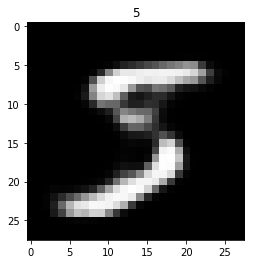

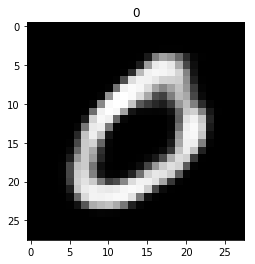

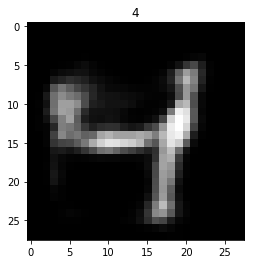

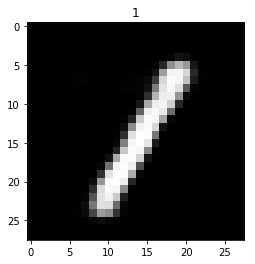

In [47]:
### Let's check if the reconstructions make sense
# Set model to test mode
VAE_MNIST.eval()
    
# Reconstructed
train_data_plot = datasets.MNIST('../data', train=True, download=True,
                   transform=transforms.ToTensor())

train_loader_plot = torch.utils.data.DataLoader(train_data_plot,
                                           batch_size=1, shuffle=False, **{})

for batch_idx, (data, _) in enumerate(train_loader_plot):
    x_hat, mu, logvar = VAE_MNIST(data)
    plt.imshow(x_hat.view(1,28,28).squeeze().data.numpy(), cmap='gray')
    plt.title('%i' % train_data.train_labels[batch_idx])
    plt.show()
    if batch_idx == 3:
        break


### 2.8 Visualize latent space (20 points)
Now, implement the auto-encoder now with a 2-dimensional latent space, and train again over the MNIST data. Make a visualization of the learned manifold by using a linearly spaced coordinate grid as input for the latent space, as seen in  https://arxiv.org/abs/1312.6114 Figure 4.

In [48]:
# YOUR CODE HERE
# raise NotImplementedError()

Z_dim = 2
fc21_dims = (H_dim, Z_dim)
fc22_dims = (H_dim, Z_dim)
fc3_dims = (Z_dim, H_dim)

# Init model
VAE_MNIST_2 = VAE(fc1_dims=fc1_dims, fc21_dims=fc21_dims, fc22_dims=fc22_dims, fc3_dims=fc3_dims, fc4_dims=fc4_dims)

# Init optimizer
optimizer_2 = optim.Adam(VAE_MNIST_2.parameters(), lr=lr)

# Train
for epoch in range(1, epochs + 1):
    train(epoch, train_loader, VAE_MNIST_2, optimizer_2)


Train Epoch: 1 [0/60000 (0%)]	Loss: 549.814697
Train Epoch: 1 [12800/60000 (21%)]	Loss: 197.594879
Train Epoch: 1 [25600/60000 (43%)]	Loss: 183.049088
Train Epoch: 1 [38400/60000 (64%)]	Loss: 193.819870
Train Epoch: 1 [51200/60000 (85%)]	Loss: 173.942337
====> Epoch: 1 Average loss: 196.1415
Train Epoch: 2 [0/60000 (0%)]	Loss: 171.744919
Train Epoch: 2 [12800/60000 (21%)]	Loss: 165.078140
Train Epoch: 2 [25600/60000 (43%)]	Loss: 167.766968
Train Epoch: 2 [38400/60000 (64%)]	Loss: 168.830414
Train Epoch: 2 [51200/60000 (85%)]	Loss: 165.760696
====> Epoch: 2 Average loss: 168.3773
Train Epoch: 3 [0/60000 (0%)]	Loss: 163.194016
Train Epoch: 3 [12800/60000 (21%)]	Loss: 169.979477
Train Epoch: 3 [25600/60000 (43%)]	Loss: 168.429703
Train Epoch: 3 [38400/60000 (64%)]	Loss: 159.182541
Train Epoch: 3 [51200/60000 (85%)]	Loss: 162.069397
====> Epoch: 3 Average loss: 164.1050
Train Epoch: 4 [0/60000 (0%)]	Loss: 170.139587
Train Epoch: 4 [12800/60000 (21%)]	Loss: 165.008255
Train Epoch: 4 [25600/

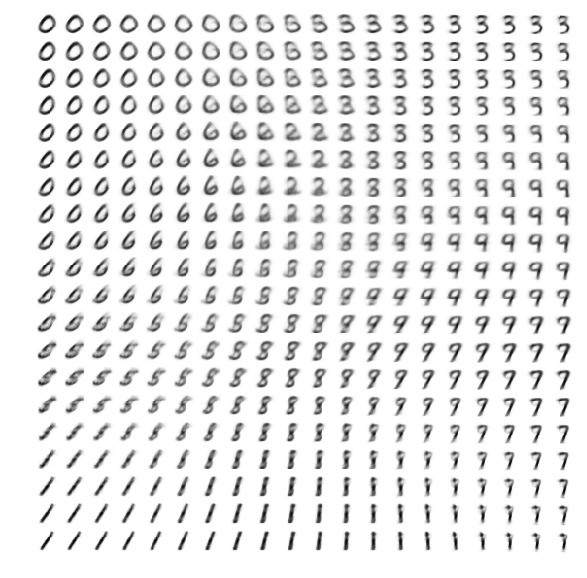

In [70]:
N = 20
D = 28
figure = np.zeros((N * D, N * D))
grid = np.linspace(-2, 2, N)

for i, x in enumerate(grid):
    for j, y in enumerate(grid):
        z = torch.FloatTensor([[x, y]])
        x_ = VAE_MNIST_2.decode(z).data.numpy()
        figure[i * D: (i + 1) * D, j * D: (j + 1) * D] = x_.reshape(D, D)
        
plt.figure(figsize=(10, 10))
plt.axis('off')
plt.imshow(figure, cmap='Greys')
plt.show()

### 2.8 Amortized inference (10 points)
What is amortized inference? Where in the code of Part 2 is it used? What is the benefit of using it?


YOUR ANSWER HERE